In [2]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

## --- Feature Selection (Variance Threshold) ---

In [3]:
data = pd.read_csv("data_preprocessed.csv")
data

,Are you self-employed?_0,Is your employer primarily a tech company/organization?_0.0,Is your employer primarily a tech company/organization?_1.0,Does your employer provide mental health benefits as part of healthcare coverage?_I don't know,Does your employer provide mental health benefits as part of healthcare coverage?_No,Does your employer provide mental health benefits as part of healthcare coverage?_Not eligible for coverage / N/A,Does your employer provide mental health benefits as part of healthcare coverage?_Yes,Do you know the options for mental health care available under your employer-provided coverage?_I am not sure,Do you know the options for mental health care available under your employer-provided coverage?_No,Do you know the options for mental health care available under your employer-provided coverage?_Yes,...,Which of the following best describes your work position?_Management / Lead,Which of the following best describes your work position?_Other,Which of the following best describes your work position?_Product Design,How many employees does your company or organization have?,"If a mental health issue prompted you to request a medical leave from work, asking for that leave would be:",How willing would you be to share with friends and family that you have a mental illness?,"If you have a mental health issue, do you feel that it interferes with your work when being treated effectively?","If you have a mental health issue, do you feel that it interferes with your work when NOT being treated effectively?",What is your age?,Do you work remotely?
0,0.0,-0.537246,0.537246,-0.624345,-0.470691,3.749627,-0.945018,1.177006,-0.662852,-0.616685,...,-0.561707,-0.324265,-0.126936,-0.482541,0.877747,0.192974,1.121357,1.147008,0.876590,0.075727
1,0.0,-0.537246,0.537246,-0.624345,2.124538,-0.266693,-0.945018,-0.849613,-0.662852,1.621572,...,-0.561707,-0.324265,-0.126936,-1.142275,0.227969,0.192974,-0.986933,-1.074357,-0.439600,-1.393667
2,0.0,-0.537246,0.537246,-0.624345,2.124538,-0.266693,-0.945018,1.177006,-0.662852,-0.616685,...,-0.561707,-0.324265,-0.126936,-1.142275,-0.421808,0.192974,1.121357,1.147008,0.876590,1.545121
3,0.0,1.861344,-1.861344,-0.624345,-0.470691,-0.266693,1.058181,-0.849613,-0.662852,1.621572,...,1.780287,-0.324265,-0.126936,-1.142275,-0.421808,0.192974,-0.284170,-1.074357,0.876590,0.075727
4,0.0,-0.537246,0.537246,-0.624345,-0.470691,-0.266693,1.058181,1.177006,-0.662852,-0.616685,...,-0.561707,-0.324265,-0.126936,1.496661,0.227969,0.192974,1.121357,0.036326,0.876590,0.075727
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1004,0.0,-0.537246,0.537246,-0.624345,-0.470691,-0.266693,1.058181,1.177006,-0.662852,-0.616685,...,1.780287,-0.324265,-0.126936,0.177193,0.227969,-1.396501,-0.986933,-2.185040,-1.755789,0.075727
1005,0.0,-0.537246,0.537246,1.601678,-0.470691,-0.266693,-0.945018,1.177006,-0.662852,-0.616685,...,-0.561707,3.083896,-0.126936,0.177193,0.227969,0.192974,-0.986933,0.036326,-0.439600,0.075727
1006,0.0,-0.537246,0.537246,-0.624345,-0.470691,-0.266693,1.058181,-0.849613,1.508633,-0.616685,...,-0.561707,-0.324265,-0.126936,0.836927,0.227969,0.987711,-0.986933,0.036326,0.876590,1.545121
1007,0.0,-0.537246,0.537246,-0.624345,-0.470691,-0.266693,1.058181,-0.849613,-0.662852,1.621572,...,-0.561707,-0.324265,-0.126936,0.177193,-1.071585,0.192974,-0.986933,-1.074357,2.192780,0.075727


In [4]:
### apply Variance Threshold
from sklearn.feature_selection import VarianceThreshold

selector = VarianceThreshold(threshold=0.01)
data_reduced = selector.fit_transform(data)

selected_features = data.columns[selector.get_support()]
data_reduced = pd.DataFrame(data_reduced, columns=selected_features)

removed_features = data.columns[~selector.get_support()]
print(list(removed_features))

['Are you self-employed?_0', 'Do you have previous employers?_1']


## --- Feature Selection (Correlation Matrix) ---

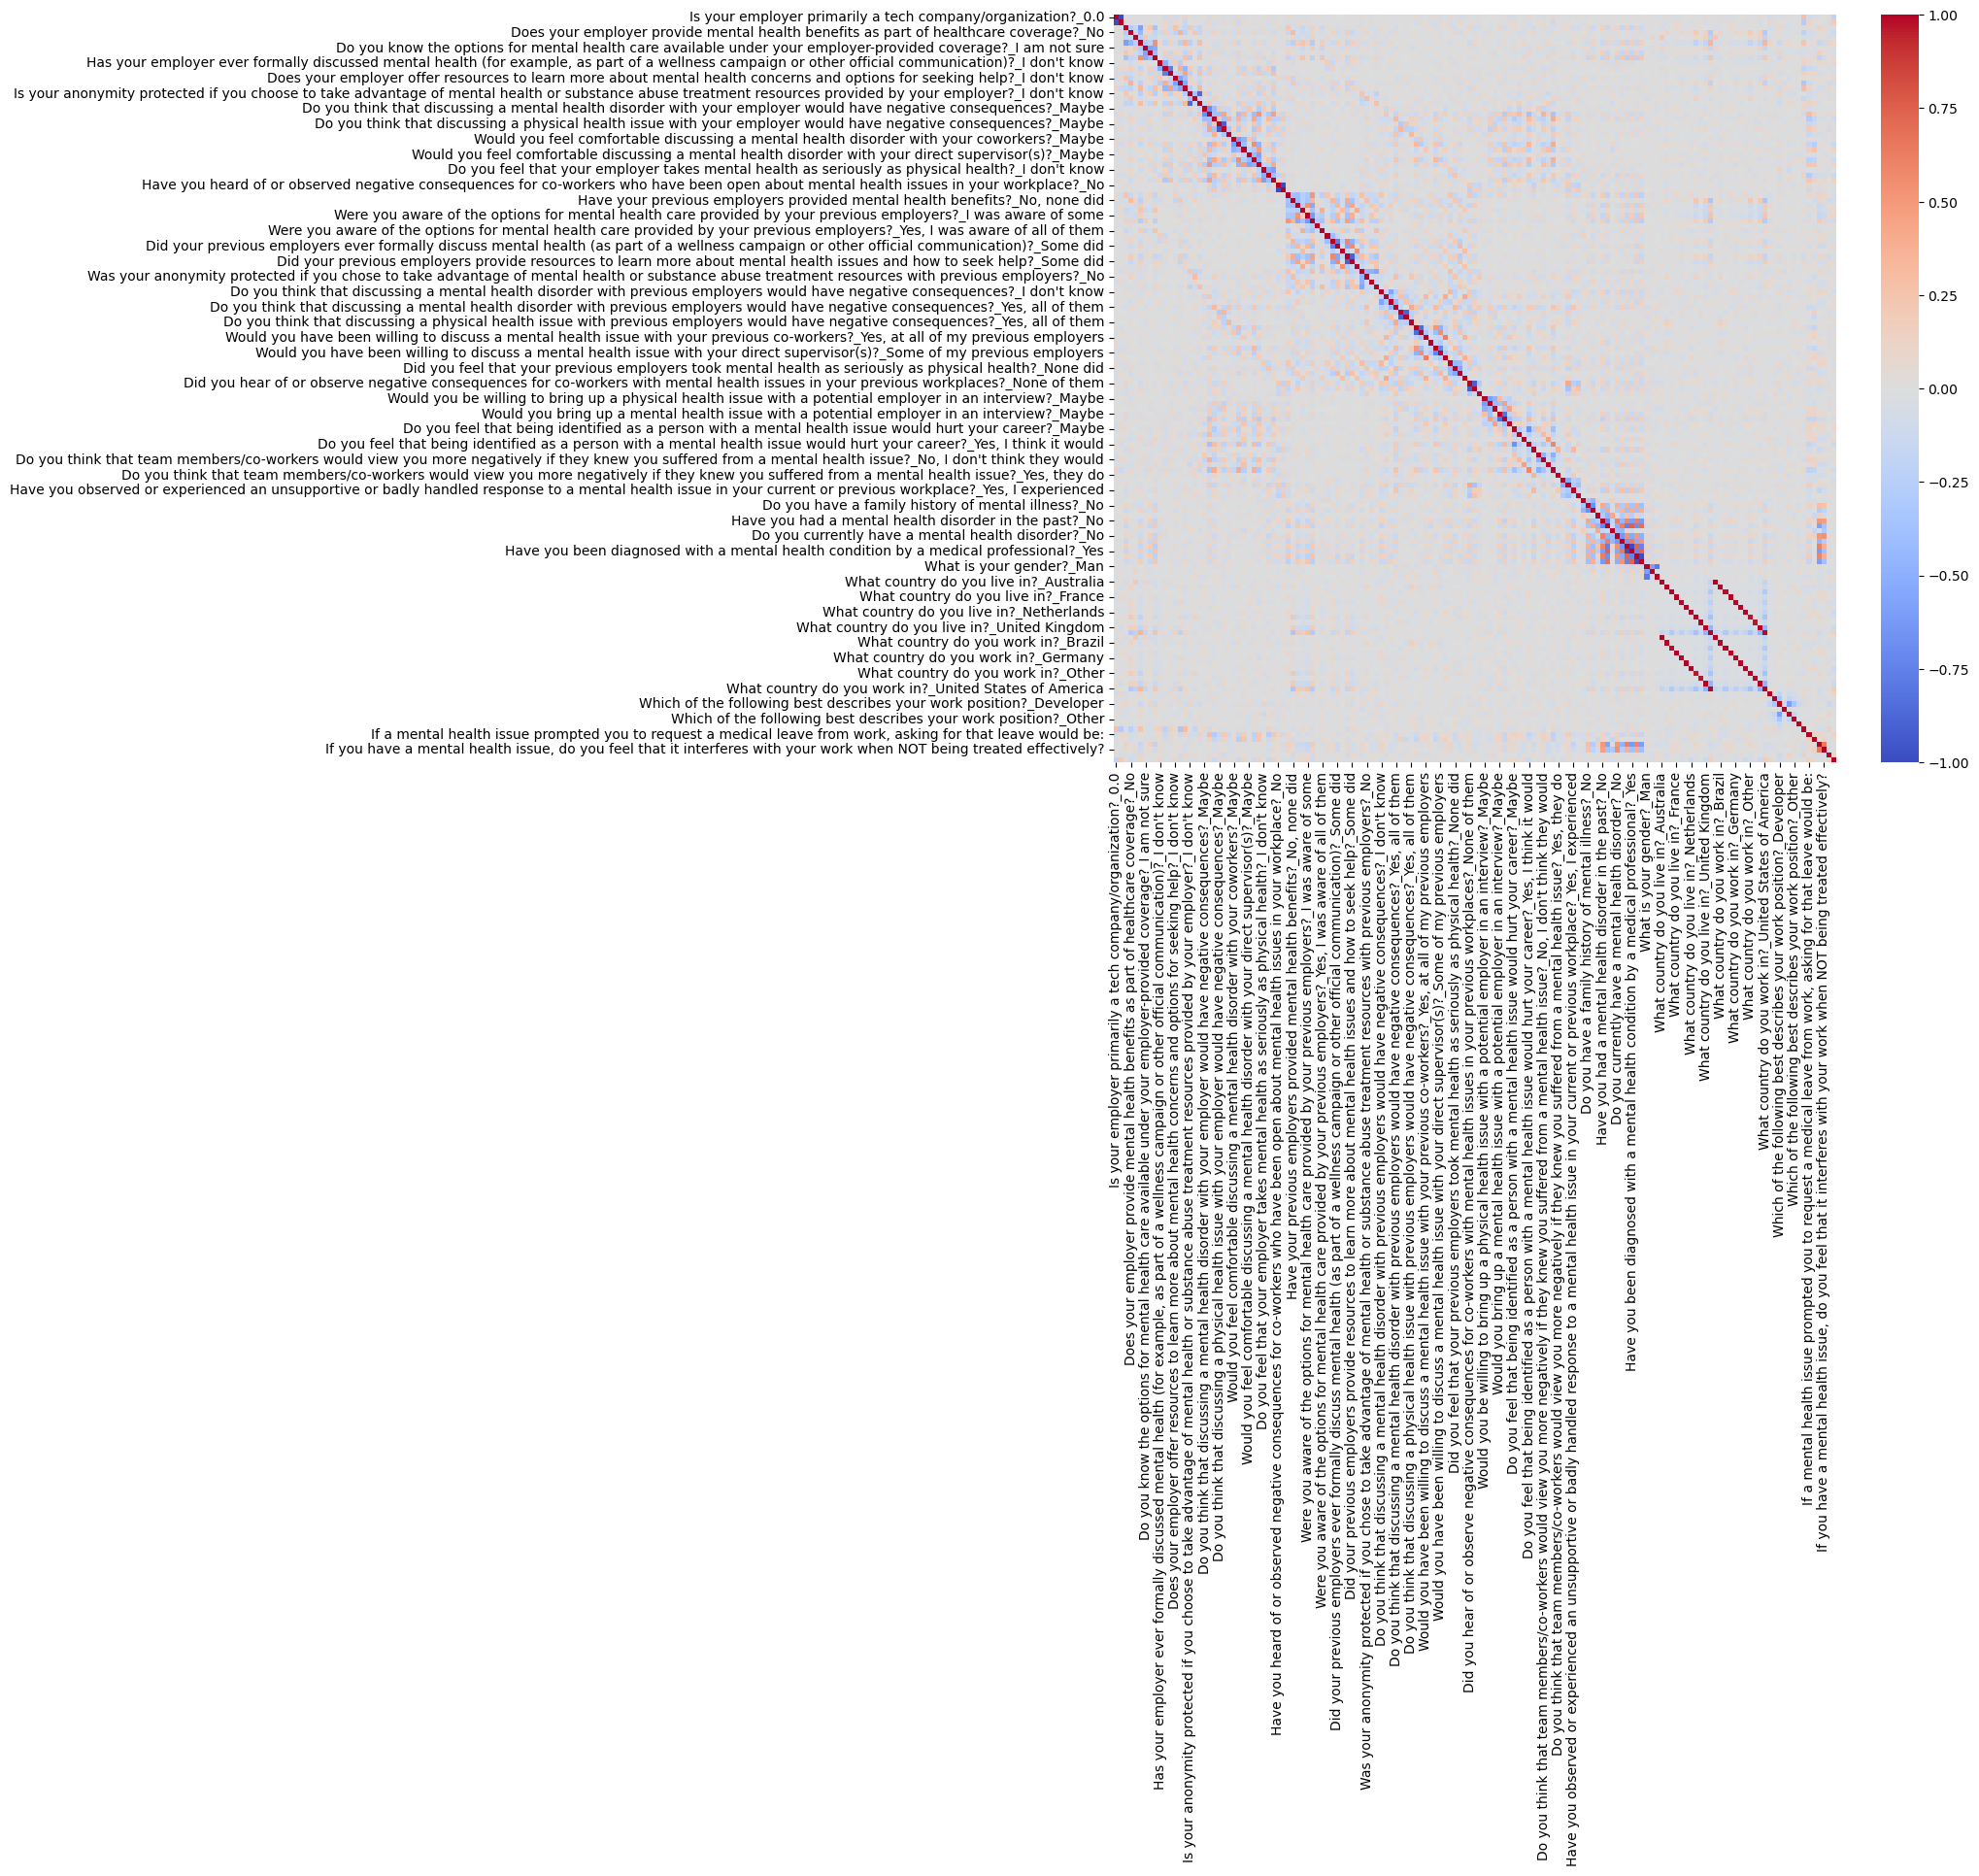

In [5]:
import seaborn as sns

corr = data_reduced.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=False, cmap="coolwarm")
plt.show()

#red → high positive correlation
#blue → high negative correlation
#white → weak or no correlation

In [6]:
# abs values
abs_corr = corr.abs()

# only upper triangular matrix to avoid duplicates
upper = abs_corr.where(np.triu(np.ones(abs_corr.shape), k=1).astype(bool))
threshold = 0.8

# find pairs with var higher than threshold
strong_pairs = [(col1, col2, upper.loc[col1, col2]) 
                for col1 in upper.columns 
                for col2 in upper.index 
                if pd.notnull(upper.loc[col1, col2]) and upper.loc[col1, col2] > threshold]

for col1, col2, corr_val in strong_pairs:
    print(f"[1]{col1}\n[2]{col2}: {corr_val:.2f}")


[1]Is your employer primarily a tech company/organization?_0.0
[2]Is your employer primarily a tech company/organization?_1.0: 1.00
[1]Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources provided by your employer?_I don't know
[2]Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources provided by your employer?_Yes: 0.86
[1]Do you think that discussing a physical health issue with your employer would have negative consequences?_Maybe
[2]Do you think that discussing a physical health issue with your employer would have negative consequences?_No: 0.91
[1]Have you heard of or observed negative consequences for co-workers who have been open about mental health issues in your workplace?_No
[2]Have you heard of or observed negative consequences for co-workers who have been open about mental health issues in your workplace?_Yes: 1.00
[1]Did your previous employers provid

In [7]:
### Delete following questions:
# Is your employer primarily a tech company/organization?_0.0
# Have you heard of or observed negative consequences for co-workers who have been open about mental health issues in your workplace?_No
# Have you been diagnosed with a mental health condition by a medical professional?_No
# Have you ever sought treatment for a mental health issue from a mental health professional?_0
# What country do you live in?_Australia
# What country do you live in?_Brazil
# What country do you live in?_Canada
# What country do you live in?_France
# What country do you live in?_Germany
# What country do you live in?_Ireland
# What country do you live in?_Netherlands
# What country do you live in?_Other
# What country do you live in?_Sweden
# What country do you live in?_United Kingdom
# What country do you live in?_United States of America

cols_to_delete = [col for col in data_reduced.columns 
                  if "What country do you live in?" in col]

cols_to_delete += [
    "Is your employer primarily a tech company/organization?_0.0",
    "Have you heard of or observed negative consequences for co-workers who have been open about mental health issues in your workplace?_No",
    "Have you been diagnosed with a mental health condition by a medical professional?_No",
    "Have you ever sought treatment for a mental health issue from a mental health professional?_0"
]

data_reduced = data_reduced.drop(columns=cols_to_delete)

In [11]:
# show all questions
for col in data_reduced.columns:
    print(col)

Is your employer primarily a tech company/organization?_1.0
Does your employer provide mental health benefits as part of healthcare coverage?_I don't know
Does your employer provide mental health benefits as part of healthcare coverage?_No
Does your employer provide mental health benefits as part of healthcare coverage?_Not eligible for coverage / N/A
Does your employer provide mental health benefits as part of healthcare coverage?_Yes
Do you know the options for mental health care available under your employer-provided coverage?_I am not sure
Do you know the options for mental health care available under your employer-provided coverage?_No
Do you know the options for mental health care available under your employer-provided coverage?_Yes
Has your employer ever formally discussed mental health (for example, as part of a wellness campaign or other official communication)?_I don't know
Has your employer ever formally discussed mental health (for example, as part of a wellness campaign or

## --- Feature Generation ---

In [12]:
employer_support_scoring = {
    "Does your employer provide mental health benefits as part of healthcare coverage?_I don't know" : 0,
    "Does your employer provide mental health benefits as part of healthcare coverage?_No" : -1,
    "Does your employer provide mental health benefits as part of healthcare coverage?_Not eligible for coverage / N/A" : 0,
    "Does your employer provide mental health benefits as part of healthcare coverage?_Yes" : 1,
    "Do you know the options for mental health care available under your employer-provided coverage?_I am not sure" : 0,
    "Do you know the options for mental health care available under your employer-provided coverage?_No" : -1,
    "Do you know the options for mental health care available under your employer-provided coverage?_Yes" : 1,
    "Has your employer ever formally discussed mental health (for example, as part of a wellness campaign or other official communication)?_I don't know" : 0,
    "Has your employer ever formally discussed mental health (for example, as part of a wellness campaign or other official communication)?_No" : -1,
    "Has your employer ever formally discussed mental health (for example, as part of a wellness campaign or other official communication)?_Yes" : 1,
    "Does your employer offer resources to learn more about mental health concerns and options for seeking help?_I don't know" : 0,
    "Does your employer offer resources to learn more about mental health concerns and options for seeking help?_No" : -1,
    "Does your employer offer resources to learn more about mental health concerns and options for seeking help?_Yes" : 1,
    "Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources provided by your employer?_I don't know" : 0,
    "Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources provided by your employer?_No" : -1,
    "Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources provided by your employer?_Yes" : 1,
    "Do you think that discussing a mental health disorder with your employer would have negative consequences?_Maybe" : 0,
    "Do you think that discussing a mental health disorder with your employer would have negative consequences?_No" : 1,
    "Do you think that discussing a mental health disorder with your employer would have negative consequences?_Yes" : -1,
    "Do you think that discussing a physical health issue with your employer would have negative consequences?_Maybe" : 0,
    "Do you think that discussing a physical health issue with your employer would have negative consequences?_No" : 1,
    "Do you think that discussing a physical health issue with your employer would have negative consequences?_Yes" : -1,
    "Would you feel comfortable discussing a mental health disorder with your coworkers?_Maybe" : 0,
    "Would you feel comfortable discussing a mental health disorder with your coworkers?_No" : -1,
    "Would you feel comfortable discussing a mental health disorder with your coworkers?_Yes" : 1,
    "Would you feel comfortable discussing a mental health disorder with your direct supervisor(s)?_Maybe" : 0,
    "Would you feel comfortable discussing a mental health disorder with your direct supervisor(s)?_No" : -1,
    "Would you feel comfortable discussing a mental health disorder with your direct supervisor(s)?_Yes" : 1,
    "Do you feel that your employer takes mental health as seriously as physical health?_I don't know" : 0,
    "Do you feel that your employer takes mental health as seriously as physical health?_No" : -1,
    "Do you feel that your employer takes mental health as seriously as physical health?_Yes" : 1,
    "Have you observed or experienced an unsupportive or badly handled response to a mental health issue in your current or previous workplace?_Maybe/Not sure" : 0,
    "Have you observed or experienced an unsupportive or badly handled response to a mental health issue in your current or previous workplace?_No" : 1,
    "Have you observed or experienced an unsupportive or badly handled response to a mental health issue in your current or previous workplace?_Yes, I experienced" : -2,
    "Have you observed or experienced an unsupportive or badly handled response to a mental health issue in your current or previous workplace?_Yes, I observed" : -1
}

prev_employer_support_scoring = {
    "Have your previous employers provided mental health benefits?_I don't know" : 0,
    "Have your previous employers provided mental health benefits?_No, none did" : -2,
    "Have your previous employers provided mental health benefits?_Some did" : 1,
    "Have your previous employers provided mental health benefits?_Yes, they all did" : 2,
    "Were you aware of the options for mental health care provided by your previous employers?_I was aware of some" : 1,
    "Were you aware of the options for mental health care provided by your previous employers?_N/A (not currently aware)" : -1,
    "Were you aware of the options for mental health care provided by your previous employers?_No, I only became aware later" : -2,
    "Were you aware of the options for mental health care provided by your previous employers?_Yes, I was aware of all of them" : 2,
    "Did your previous employers ever formally discuss mental health (as part of a wellness campaign or other official communication)?_I don't know" : 0,
    "Did your previous employers ever formally discuss mental health (as part of a wellness campaign or other official communication)?_None did" : -2,
    "Did your previous employers ever formally discuss mental health (as part of a wellness campaign or other official communication)?_Some did" : 1,
    "Did your previous employers ever formally discuss mental health (as part of a wellness campaign or other official communication)?_Yes, they all did" : 2,
    "Did your previous employers provide resources to learn more about mental health issues and how to seek help?_None did" : -2,
    "Did your previous employers provide resources to learn more about mental health issues and how to seek help?_Some did" : 1,
    "Did your previous employers provide resources to learn more about mental health issues and how to seek help?_Yes, they all did" : 2,
    "Was your anonymity protected if you chose to take advantage of mental health or substance abuse treatment resources with previous employers?_I don't know" : 0,
    "Was your anonymity protected if you chose to take advantage of mental health or substance abuse treatment resources with previous employers?_No" : -2,
    "Was your anonymity protected if you chose to take advantage of mental health or substance abuse treatment resources with previous employers?_Sometimes" : 1,
    "Was your anonymity protected if you chose to take advantage of mental health or substance abuse treatment resources with previous employers?_Yes, always" : 2,
    "Do you think that discussing a mental health disorder with previous employers would have negative consequences?_I don't know" : 0,
    "Do you think that discussing a mental health disorder with previous employers would have negative consequences?_None of them" : 2,
    "Do you think that discussing a mental health disorder with previous employers would have negative consequences?_Some of them" : -1,
    "Do you think that discussing a mental health disorder with previous employers would have negative consequences?_Yes, all of them" : -2,
    "Do you think that discussing a physical health issue with previous employers would have negative consequences?_None of them" : 2,
    "Do you think that discussing a physical health issue with previous employers would have negative consequences?_Some of them" : -1,
    "Do you think that discussing a physical health issue with previous employers would have negative consequences?_Yes, all of them" : -2,
    "Would you have been willing to discuss a mental health issue with your previous co-workers?_No, at none of my previous employers" : -2,
    "Would you have been willing to discuss a mental health issue with your previous co-workers?_Some of my previous employers" : 1,
    "Would you have been willing to discuss a mental health issue with your previous co-workers?_Yes, at all of my previous employers" : 2,
    "Would you have been willing to discuss a mental health issue with your direct supervisor(s)?_I don't know" : 0,
    "Would you have been willing to discuss a mental health issue with your direct supervisor(s)?_No, at none of my previous employers" : -2,
    "Would you have been willing to discuss a mental health issue with your direct supervisor(s)?_Some of my previous employers" : 1,
    "Would you have been willing to discuss a mental health issue with your direct supervisor(s)?_Yes, at all of my previous employers" : 2,
    "Did you feel that your previous employers took mental health as seriously as physical health?_I don't know" : 0,
    "Did you feel that your previous employers took mental health as seriously as physical health?_None did" : -2,
    "Did you feel that your previous employers took mental health as seriously as physical health?_Some did" : 1,
    "Did you feel that your previous employers took mental health as seriously as physical health?_Yes, they all did" : 2,
    "Did you hear of or observe negative consequences for co-workers with mental health issues in your previous workplaces?_None of them" : 2,
    "Did you hear of or observe negative consequences for co-workers with mental health issues in your previous workplaces?_Some of them" : -1,
    "Did you hear of or observe negative consequences for co-workers with mental health issues in your previous workplaces?_Yes, all of them" : -2,
    "Have you observed or experienced an unsupportive or badly handled response to a mental health issue in your current or previous workplace?_Maybe/Not sure" : 0,
    "Have you observed or experienced an unsupportive or badly handled response to a mental health issue in your current or previous workplace?_No" : 1,
    "Have you observed or experienced an unsupportive or badly handled response to a mental health issue in your current or previous workplace?_Yes, I experienced" : -2,
    "Have you observed or experienced an unsupportive or badly handled response to a mental health issue in your current or previous workplace?_Yes, I observed" : -1
}

openness_scoring = {
    "Would you be willing to bring up a physical health issue with a potential employer in an interview?_Maybe" : 0,
    "Would you be willing to bring up a physical health issue with a potential employer in an interview?_No" : -1,
    "Would you be willing to bring up a physical health issue with a potential employer in an interview?_Yes" : 1,
    "Would you bring up a mental health issue with a potential employer in an interview?_Maybe" : 0,
    "Would you bring up a mental health issue with a potential employer in an interview?_No" : -1,
    "Would you bring up a mental health issue with a potential employer in an interview?_Yes" : 1,
}

perceived_stigma_scoring = {
    "Do you feel that being identified as a person with a mental health issue would hurt your career?_Maybe" : 0,
    "Do you feel that being identified as a person with a mental health issue would hurt your career?_No, I don't think it would" : 1,
    "Do you feel that being identified as a person with a mental health issue would hurt your career?_No, it has not" : 2,
    "Do you feel that being identified as a person with a mental health issue would hurt your career?_Yes, I think it would" : -1,
    "Do you feel that being identified as a person with a mental health issue would hurt your career?_Yes, it has" : -2,
    "Do you think that team members/co-workers would view you more negatively if they knew you suffered from a mental health issue?_Maybe" : 0,
    "Do you think that team members/co-workers would view you more negatively if they knew you suffered from a mental health issue?_No, I don't think they would" : 1,
    "Do you think that team members/co-workers would view you more negatively if they knew you suffered from a mental health issue?_No, they do not" : 2,
    "Do you think that team members/co-workers would view you more negatively if they knew you suffered from a mental health issue?_Yes, I think they would" : -1,
    "Do you think that team members/co-workers would view you more negatively if they knew you suffered from a mental health issue?_Yes, they do" : -2,
}

mh_status_scoring = {
    "Do you have a family history of mental illness?_I don't know" : 0,
    "Do you have a family history of mental illness?_No" : 1,
    "Do you have a family history of mental illness?_Yes" : -1,
    "Have you had a mental health disorder in the past?_Maybe" : 0,
    "Have you had a mental health disorder in the past?_No" : 2,
    "Have you had a mental health disorder in the past?_Yes" : -2,
    "Do you currently have a mental health disorder?_Maybe" : 0,
    "Do you currently have a mental health disorder?_No" : 3,
    "Do you currently have a mental health disorder?_Yes" : -3,
    "Have you been diagnosed with a mental health condition by a medical professional?_Yes" : -2,
    "Have you ever sought treatment for a mental health issue from a mental health professional?_1" : 1
}

(1009, 132)